In [1]:
require(data.table)
library(DESeq2)
library(gplots)
library(calibrate)
library(colorspace)
library(RColorBrewer)

Loading required package: data.table
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,

In [2]:
setwd("/home/veraalva/projects/rna-seq/results/PRJNA339968/differential_expression")

In [3]:
prefix <- "^"
condition1 <- "classical"
condition1exp <- paste(prefix, condition1, sep="")
condition2 <- "nonclassical"
condition2exp <- paste(prefix, condition2, sep="")
factors = as.data.frame(fread("../../../data/PRJNA339968/PRJNA339968_SraRunTable.tsv"))
condition <- c()
for(i in factors$Sample_Name){
    if (grepl(condition1exp, i)){
        condition <- c(condition,condition1)
    }else if (grepl(condition2exp, i)){
        condition <- c(condition,condition2)
    }
}
factors$Condition <- as.factor(condition)
head(factors)
nrow(factors)

BioSample,Experiment,Library_Name,LoadDate,MBases,MBytes,Run,SRA_Sample,Sample_Name,isolate,...,LibrarySource,Organism,Platform,ReleaseDate,SRA_Study,age,biomaterial_provider,sex,tissue,Condition
SAMN05616144,SRX2043366,classical01,2016-08-24,641,491,SRR4053795,SRS1636082,classical01,classical01,...,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2016-12-20,SRP082682,Not collected,Kim lab,Not collected,FACS-purified monocytes,classical
SAMN05616145,SRX2043367,classical02,2016-08-24,1623,1196,SRR4053796,SRS1636083,classical02,classical02,...,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2016-12-20,SRP082682,Not collected,Kim lab,Not collected,FACS-purified monocytes,classical
SAMN05616154,SRX2043368,classical13,2016-08-24,1405,973,SRR4053797,SRS1636084,classical13,classical13,...,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2016-12-20,SRP082682,Not collected,Kim lab,Not collected,FACS-purified monocytes,classical
SAMN05616155,SRX2043369,classical14,2016-08-24,1170,818,SRR4053798,SRS1636085,classical14,classical14,...,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2016-12-20,SRP082682,Not collected,Kim lab,Not collected,FACS-purified monocytes,classical
SAMN05616156,SRX2043370,classical15,2016-08-24,666,474,SRR4053799,SRS1636086,classical15,classical15,...,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2016-12-20,SRP082682,Not collected,Kim lab,Not collected,FACS-purified monocytes,classical
SAMN05616157,SRX2043371,classical16,2016-08-24,881,641,SRR4053800,SRS1636087,classical16,classical16,...,TRANSCRIPTOMIC,Homo sapiens,ILLUMINA,2016-12-20,SRP082682,Not collected,Kim lab,Not collected,FACS-purified monocytes,classical


[1] 34

In [4]:
min_p_value = 0.05
highlight_color = "red"
min_count = 10
min_number_samples = length(condition[condition == 'classical'])

In [5]:
data <- as.data.frame(fread("../quantification/ExonReads.tsv"))
data <- data[,c(c(1,2,3,4,5),match(factors$Run,names(data)))]
nrow(data)
head(data)

[1] 50151

Gene_Id,Chr,Start,End,ExonLength,SRR4053795,SRR4053796,SRR4053797,SRR4053798,SRR4053799,...,SRR4053819,SRR4053820,SRR4053822,SRR4053821,SRR4053823,SRR4053824,SRR4053825,SRR4098781,SRR4098782,SRR4098783
ENSG00000237683.5,chr1,134900,139378,2661,43,4,59,61,22,...,85,34,29,390,3,12,38,100,105,106
ENSG00000241860.2,chr1,141473,173861,6195,4,0,0,33,13,...,5,7,6,15,1,1,37,15,15,10
ENSG00000230021.3,chr1,536815,659929,1697,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000225972.1,chr1,564441,564812,372,769,14,2610,11,8,...,1025,1835,6,2314,456,11,1361,2019,6,929
ENSG00000225630.1,chr1,565019,566062,1044,537,1490,2668,1569,563,...,1069,1283,857,1115,223,270,649,1294,1594,806
ENSG00000237973.1,chr1,566453,567995,1543,1024,1164,125,3023,137,...,3508,1758,2916,2128,2517,965,6273,11805,3226,7501


In [6]:
data.counts <- data[, -c(1:5)]
data.counts[is.na(data.counts)] <- 0
row.names(data.counts) <- data[, 1]
data.counts[] <- as.integer(round(as.matrix(data.counts)))
keep <- (rowSums(data.counts > min_count) >= min_number_samples)
genes_filtered <- rownames(data.counts[keep, ])
data.counts <- data.counts[genes_filtered,]
data <- subset(data, data$Gene_Id %in% genes_filtered)
nrow(data.counts)
head(data.counts)

[1] 9619

,SRR4053795,SRR4053796,SRR4053797,SRR4053798,SRR4053799,SRR4053800,SRR4053801,SRR4053802,SRR4053803,SRR4053804,...,SRR4053819,SRR4053820,SRR4053822,SRR4053821,SRR4053823,SRR4053824,SRR4053825,SRR4098781,SRR4098782,SRR4098783
ENSG00000237683.5,43,4,59,61,22,45,7,4,0,48,...,85,34,29,390,3,12,38,100,105,106
ENSG00000225972.1,769,14,2610,11,8,979,254,136,3,4,...,1025,1835,6,2314,456,11,1361,2019,6,929
ENSG00000225630.1,537,1490,2668,1569,563,552,145,185,175,861,...,1069,1283,857,1115,223,270,649,1294,1594,806
ENSG00000237973.1,1024,1164,125,3023,137,2161,557,363,871,218,...,3508,1758,2916,2128,2517,965,6273,11805,3226,7501
ENSG00000229344.1,21,67,59,19,8,18,2,6,10,18,...,63,26,17,30,4,14,24,24,53,31
ENSG00000248527.1,1040,3171,3122,3058,1510,1258,490,232,1190,1678,...,3023,1879,1745,3805,716,778,1766,3765,2890,2326


In [7]:
dds <- DESeqDataSetFromMatrix(countData = data.counts,
                              colData = factors,
                              design = ~ Condition)
dds <- DESeq(dds)
res <- lfcShrink(dds, coef="Condition_nonclassical_vs_classical", type="apeglm")
res <- results(dds, alpha=min_p_value)
resOrdered <- res[order(res$padj),]

resOrdered_data <- as.data.frame(resOrdered)
resOrdered_data <- data.frame("Gene_Id"=rownames(resOrdered_data),resOrdered_data)
resOrdered_data <- resOrdered_data[!is.na(resOrdered_data$padj), ]

count <- nrow(resOrdered_data[resOrdered_data$padj <= min_p_value,])
print(paste('Genes with FDR >=', min_p_value, count))

file_name = "deseq2.csv"
res_data <- resOrdered_data[resOrdered_data$padj <= min_p_value & !is.na(resOrdered_data$padj), ]
write.table(res_data, file_name, row.names=F, na="NA", append = F, quote= FALSE, sep = ",", col.names = T)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 1977 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895


[1] "Genes with FDR >= 0.05 3315"


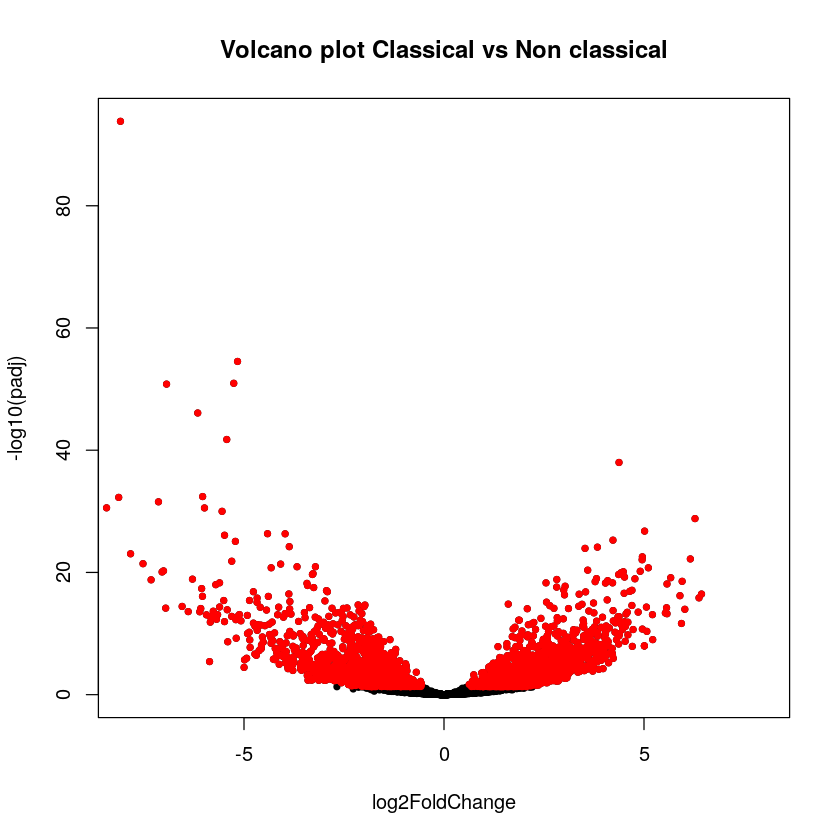

In [8]:
with(resOrdered_data, plot(log2FoldChange, -log10(padj), pch=20, main="Volcano plot Classical vs Non classical", xlim=c(-8,8)))
with(subset(resOrdered_data, padj <= min_p_value), points(log2FoldChange, -log10(padj), pch=20, col=highlight_color))


In [9]:
yy <- log2(counts(dds, normalized=TRUE))
topVarGenes <- rownames(resOrdered_data)
selY <- yy[topVarGenes,]
colnames(selY) <- paste(factors$Condition, colnames(selY), sep = "_")
selY[which(!is.finite(selY))] <- 0
head(selY)

,classical_SRR4053795,classical_SRR4053796,classical_SRR4053797,classical_SRR4053798,classical_SRR4053799,classical_SRR4053800,classical_SRR4053801,nonclassical_SRR4053802,nonclassical_SRR4053803,nonclassical_SRR4053804,...,nonclassical_SRR4053819,classical_SRR4053820,classical_SRR4053822,classical_SRR4053821,classical_SRR4053823,classical_SRR4053824,classical_SRR4053825,classical_SRR4098781,classical_SRR4098782,nonclassical_SRR4098783
ENSG00000143546.5,16.359646,16.87054,15.380944,14.568550,15.38308,14.077145,14.151322,7.425637,2.813026,6.9818263,...,7.303145,14.57613,13.383807,15.566389,13.812649,13.533983,14.944285,14.58106,15.752060,7.77501
ENSG00000163221.7,11.774556,12.88709,11.625338,11.127783,12.12521,10.030765,10.773185,0.000000,0.000000,0.8443228,...,0.000000,10.87382,10.559520,12.382083,9.882154,10.063482,11.669613,11.35466,11.979547,0.00000
ENSG00000090382.2,17.814128,18.04094,18.518498,17.468347,17.58494,16.997618,17.581061,11.759153,14.552385,12.4253350,...,12.240631,19.63753,16.883495,18.897527,17.322898,16.457606,17.969374,17.32225,17.304009,12.72674
ENSG00000137801.9,15.091435,16.55598,19.489799,17.096167,16.99307,17.246697,16.507133,5.278795,3.813026,4.7512134,...,4.531655,17.31451,17.366899,19.031243,15.765978,17.276223,17.449640,16.62801,16.110122,5.77501
ENSG00000197632.4,12.551145,12.68457,11.380676,13.909878,12.45524,14.270038,13.491976,4.278795,0.000000,5.3037544,...,0.000000,12.70159,15.545675,14.868759,11.744280,14.757139,14.035902,14.26293,13.853784,0.00000
ENSG00000241544.1,8.334093,10.39810,8.932118,9.050578,8.16794,9.901561,7.601095,0.000000,0.000000,0.0000000,...,0.000000,11.71182,8.648628,4.254641,7.420608,7.534818,6.639546,7.95391,5.874152,0.00000


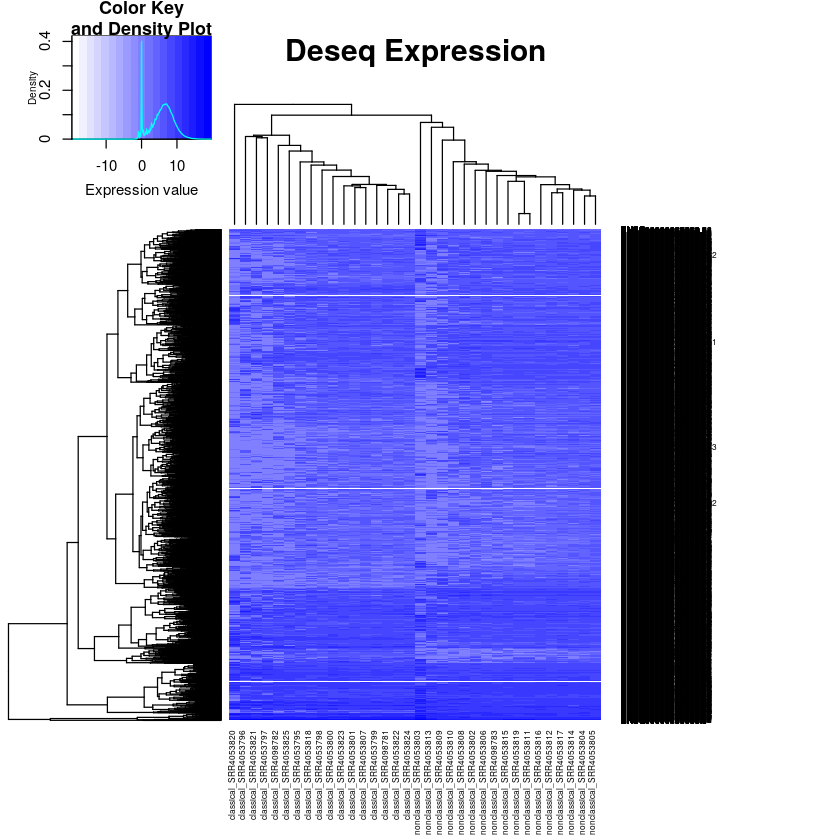

In [10]:
pal <- colorRampPalette(c("white","blue"))
heatmap.2(selY, col=pal, Rowv=T, Colv=T,
          dendrogram = c("both"),
          trace="none",
          density.info=c("density"),
          key.xlab="Expression value",
          key.ylab="Density",
          main="Deseq Expression",
          cexCol=.5,
          offsetCol=.0,
          cexRow=.5,
          margins=c(6,12),
          breaks=20,
          key=T,)

In [11]:
res

log2 fold change (MLE): Condition nonclassical vs classical 
Wald test p-value: Condition nonclassical vs classical 
DataFrame with 9619 rows and 6 columns
                          baseMean     log2FoldChange             lfcSE
                         <numeric>          <numeric>         <numeric>
ENSG00000237683.5  42.624321228243  -1.64918043974803 0.533587735826699
ENSG00000225972.1 509.031327251994  -1.68996999998532 0.763969839922962
ENSG00000225630.1 638.952261400049  -1.02721942197593  0.28682486636904
ENSG00000237973.1 1788.16544661139 -0.372917505053237  0.51198292281895
ENSG00000229344.1 19.6431150787464 -0.588377437344973 0.413296902956532
...                            ...                ...               ...
ENSG00000237090.1 10.9845787247757    1.8878719738524 0.807557976521661
ENSG00000270194.1 15.5124973532726   2.14838049559083 0.926605661612718
ENSG00000176354.2 15.5441812660533    2.1520042795565 0.926597750600515
ENSG00000260841.1 30.3687920568838   3.4342020477020